In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from sklearn import model_selection
import torchvision.transforms as transforms
import torchvision.io 
import librosa
from PIL import Image
import albumentations as alb
import torch.multiprocessing as mp
import warnings
import random

warnings.filterwarnings('ignore')

In [75]:
from pytorch_lightning.callbacks import ModelCheckpoint, BackboneFinetuning, EarlyStopping


In [76]:
!pip install -q torchtoolbox timm


In [77]:
class Config:  # 设置config
    use_aug = False
    num_classes = 264  # 鸟的种类数 
    batch_size = 64  # 训练batch_size
    epochs = 12  # 训练epoch数
    PRECISION = 16  # 训练数据精度
    PATIENCE = 8  # earlystop patience
    seed = 2023
    model = "tf_efficientnet_b0_ns"
    pretrained = True            
    weight_decay = 1e-3
    use_mixup = True  # 使用mixup
    mixup_alpha = 0.5   # mixup参数设置
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    

    data_root = "/kaggle/input/birdclef-2023/"  # 预先处理好的数据
    train_images = "/kaggle/input/split-creating-melspecs-stage-1/specs/train/"
    valid_images = "/kaggle/input/split-creating-melspecs-stage-1/specs/valid/"
    train_path = "/kaggle/input/bc2023-train-val-df/train.csv"
    valid_path = "/kaggle/input/bc2023-train-val-df/valid.csv"
    
    mask_prob = 0.52  # 进行数据增广的概率
    freq_mask = 20  # 频域mask的最小大小
    time_mask = 30  # 时域mask的最小大小
    mixup_prob = 0.65  # mixup的概率
    mixup_times = 20  # 每个batch内进行20次mixup
    mixup_alpha = 0.5
    
    SR = 32000  # 音频采样参数
    DURATION = 5
    MAX_READ_SAMPLES = 5
    LR = 5e-4
    

In [78]:
pl.seed_everything(Config.seed, workers=True)

2023

In [79]:
def config_to_dict(cfg):
    return dict((name, getattr(cfg, name)) for name in dir(cfg) if not name.startswith('__'))

In [80]:
df_train = pd.read_csv(Config.train_path)
df_valid = pd.read_csv(Config.valid_path)
df_train.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,len_sec_labels,path,frames,sr,duration
0,yebapa1,[],['song'],-3.3923,36.7049,Apalis flavida,Yellow-breasted Apalis,isaac kilusu,Creative Commons Attribution-NonCommercial-Sha...,3.0,https://www.xeno-canto.org/422175,yebapa1/XC422175.ogg,0,/kaggle/input/birdclef-2023/train_audio/yebapa...,405504,32000,12.672000
1,yebapa1,[],['song'],-0.6143,34.0906,Apalis flavida,Yellow-breasted Apalis,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.0,https://www.xeno-canto.org/289562,yebapa1/XC289562.ogg,0,/kaggle/input/birdclef-2023/train_audio/yebapa...,796630,32000,24.894687
2,combuz1,[],['call'],51.8585,-8.2699,Buteo buteo,Common Buzzard,Irish Wildlife Sounds,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/626969,combuz1/XC626969.ogg,0,/kaggle/input/birdclef-2023/train_audio/combuz...,254112,32000,7.941000
3,chibat1,['laudov1'],"['adult', 'sex uncertain', 'song']",-33.1465,26.4001,Batis molitor,Chinspot Batis,Lynette Rudman,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/664196,chibat1/XC664196.ogg,1,/kaggle/input/birdclef-2023/train_audio/chibat...,1040704,32000,32.522000
4,carcha1,[],['song'],-34.0110,18.8078,Cossypha caffra,Cape Robin-Chat,Shannon Ronaldson,Creative Commons Attribution-NonCommercial-Sha...,1.0,https://www.xeno-canto.org/322333,carcha1/XC322333.ogg,0,/kaggle/input/birdclef-2023/train_audio/carcha...,40124,32000,1.253875


In [81]:
Config.num_classes = len(df_train.primary_label.unique())

In [82]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['primary_label'])], axis=1)
df_valid = pd.concat([df_valid, pd.get_dummies(df_valid['primary_label'])], axis=1)

## Create & Fill birds with 0 samples in validation

In [83]:
birds = list(df_train.primary_label.unique())

In [84]:
missing_birds = list(set(list(df_train.primary_label.unique())).difference(list(df_valid.primary_label.unique())))

In [85]:
non_missing_birds = list(set(list(df_train.primary_label.unique())).difference(missing_birds))

In [86]:
len(non_missing_birds)

254

In [87]:
df_valid[missing_birds] = 0
df_valid = df_valid[df_train.columns] ## Fix order

In [88]:
# df_train.iloc[:,17:]

In [89]:
import albumentations as A
def get_train_transform():  # 将数据载入
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
                A.Cutout(max_h_size=5, max_w_size=16),
                A.CoarseDropout(max_holes=4),
            ], p=0.5),
    ])

In [90]:
class BirdDataset(torch.utils.data.Dataset):

    def __init__(self, df, sr = Config.SR, duration = Config.DURATION, augmentations = None, train = True):

        self.df = df
        self.sr = sr 
        self.train = train
        self.duration = duration
        self.augmentations = augmentations
        if train:
            self.img_dir = Config.train_images
        else:
            self.img_dir = Config.valid_images

    def __len__(self):
        return len(self.df)

    @staticmethod
    def normalize(image):
        image = image / 255.0
        #image = torch.stack([image, image, image])
        return image

    def __getitem__(self, idx):

        row = self.df.iloc[idx]
        impath = self.img_dir + f"{row.filename}.npy"

        image = np.load(str(impath))[:Config.MAX_READ_SAMPLES]
        
        ########## RANDOM SAMPLING ################
        if self.train:
            image = image[np.random.choice(len(image))]
        else:
            image = image[0]
            
        #####################################################################
        
        image = torch.tensor(image).float()

        if self.augmentations:
#             image = self.augmentations(image.unsqueeze(0)).squeeze()
            image = self.augmentations(image)
            
        image.size()
        
        image = torch.stack([image, image, image])

        image = self.normalize(image)


        return image, torch.tensor(row[17:]).float()


# augment

In [91]:
def time_mask(img, param):  # 时域mask
    time_max = img.shape[0]
    t = random.randint(0, param)
    t0 = random.randint(0, time_max - t)
    mask = torch.ones_like(img, device=img.device)
    mask[t0: t0 + t, :] = 0
    return img * mask

def freq_mask(img, param):  # 频域mask
    freq_max = img.shape[1]
    t = random.randint(0, param)
    t0 = random.randint(0, freq_max - t)
    mask = torch.ones_like(img, device=img.device)
    mask[:, t0: t0 + t] = 0
    return img * mask

def my_aug(img):  # 集成两个mask
    if random.random() < Config.mask_prob:
        img = time_mask(img, Config.time_mask)
        img = freq_mask(img, Config.freq_mask)
    return img

In [92]:
def get_fold_dls(df_train, df_valid):  # 获取训练的数据集和dataloader

    ds_train = BirdDataset(
        df_train, 
        sr = Config.SR,
        duration = Config.DURATION,
        augmentations = my_aug,
        train = True
    )
    ds_val = BirdDataset(
        df_valid, 
        sr = Config.SR,
        duration = Config.DURATION,
        augmentations = None,
        train = False
    )
    dl_train = DataLoader(ds_train, batch_size=Config.batch_size , shuffle=True, num_workers = 2)    
    dl_val = DataLoader(ds_val, batch_size=Config.batch_size, num_workers = 2)
    return dl_train, dl_val, ds_train, ds_val

In [93]:
def show_batch(img_ds, num_items, num_rows, num_cols, predict_arr=None):  # 展示以检查数据载入是否正确
    fig = plt.figure(figsize=(12, 6))     
    img_index = np.random.randint(0, len(img_ds)-1, num_items)
    for index, img_index in enumerate(img_index):  # list first 9 images
        img, lb = img_ds[img_index]        
        ax = fig.add_subplot(num_rows, num_cols, index + 1, xticks=[], yticks=[])
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        if isinstance(img, np.ndarray):
            img = img.transpose(1, 2, 0)
            ax.imshow(img)        
            
        title = f"Spec"
        ax.set_title(title)  

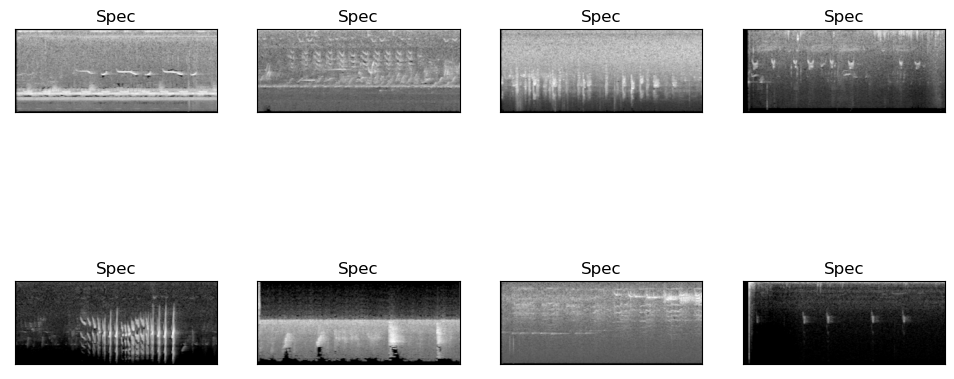

In [94]:
dl_train, dl_val, ds_train, ds_val = get_fold_dls(df_train, df_valid)
show_batch(ds_val, 8, 2, 4)
# print(ds_train[2][0].shape)

In [95]:
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau, OneCycleLR

def get_optimizer(lr, params):
    model_optimizer = torch.optim.Adam(  # 对所有没冻结参数的层使用Adam优化器
            filter(lambda p: p.requires_grad, params), 
            lr=lr,
            weight_decay=Config.weight_decay
        )
    interval = "epoch"
    
    lr_scheduler = CosineAnnealingWarmRestarts(  # 使用余弦退火来更新lr
                            model_optimizer, 
                            T_0=Config.epochs, 
                            T_mult=1, 
                            eta_min=1e-6, 
                            last_epoch=-1
                        )

    return {
        "optimizer": model_optimizer, 
        "lr_scheduler": {
            "scheduler": lr_scheduler,
            "interval": interval,
            "monitor": "val_loss",
            "frequency": 1
        }
    }

In [96]:
from torchtoolbox.tools import mixup_data, mixup_criterion
import torch.nn as nn
from torch.nn.functional import cross_entropy
import torchmetrics
import timm

In [97]:
import sklearn.metrics

def padded_cmap(solution, submission, padding_factor=5):  # 指标cmAP的计算
    solution = solution#.drop(['row_id'], axis=1, errors='ignore')
    submission = submission#.drop(['row_id'], axis=1, errors='ignore')
    new_rows = []
    for i in range(padding_factor):
        new_rows.append([1 for i in range(len(solution.columns))])
    new_rows = pd.DataFrame(new_rows)
    new_rows.columns = solution.columns
    padded_solution = pd.concat([solution, new_rows]).reset_index(drop=True).copy()
    padded_submission = pd.concat([submission, new_rows]).reset_index(drop=True).copy()
    score = sklearn.metrics.average_precision_score(
        padded_solution.values,
        padded_submission.values,
        average='macro',
    )
    return score

def map_score(solution, submission):
    solution = solution#.drop(['row_id'], axis=1, errors='ignore')
    submission = submission#.drop(['row_id'], axis=1, errors='ignore')
    score = sklearn.metrics.average_precision_score(
        solution.values,
        submission.values,
        average='micro',
    )
    return score

In [98]:
dummy = df_valid[birds].copy()
dummy[birds] = np.random.rand(dummy.shape[0],dummy.shape[1])

In [99]:
padded_cmap(df_valid[birds], dummy[birds], padding_factor = 5)

0.4744901328261848

In [100]:
padded_cmap(df_valid[birds], dummy[birds], padding_factor = 1)

0.21267579101636477

In [101]:
map_score(df_valid[birds], dummy[birds])

0.00372183159576223

In [102]:
class BirdClefModel(pl.LightningModule):
    def __init__(self, model_name=Config.model, num_classes = Config.num_classes, pretrained = Config.pretrained):
        super().__init__()
        self.num_classes = num_classes

        self.backbone = timm.create_model(model_name, pretrained=pretrained)

        if 'res' in model_name:
            self.in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Linear(self.in_features, num_classes)
        elif 'dense' in model_name:
            self.in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Linear(self.in_features, num_classes)
        elif 'efficientnet' in model_name:
            self.in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Sequential(
                nn.Linear(self.in_features, num_classes)
            )
        
        self.loss_function = nn.BCEWithLogitsLoss() 

    def forward(self,images):
        logits = self.backbone(images)
        return logits
        
    def configure_optimizers(self):
        return get_optimizer(lr=Config.LR, params=self.parameters())

    def train_with_mixup(self, X, y):  # 在mixup下进行训练
        X, y_a, y_b, lam = mixup_data(X, y, alpha=Config.mixup_alpha)
        y_pred = self(X)
        loss_mixup = mixup_criterion(cross_entropy, y_pred, y_a, y_b, lam)
        return loss_mixup

    def training_step(self, batch, batch_idx):
        image, target = batch        
        if Config.use_mixup:
            loss = self.train_with_mixup(image, target)
        else:
            y_pred = self(image)
            loss = self.loss_function(y_pred,target)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss        

    def validation_step(self, batch, batch_idx):
        image, target = batch     
        y_pred = self(image)
        val_loss = self.loss_function(y_pred, target)
        self.log("val_loss", val_loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        
        return {"val_loss": val_loss, "logits": y_pred, "targets": target}
    
    def train_dataloader(self):
        return self._train_dataloader 
    
    def validation_dataloader(self):
        return self._validation_dataloader
    
    def validation_epoch_end(self,outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        output_val = torch.cat([x['logits'] for x in outputs],dim=0).sigmoid().cpu().detach().numpy()
        target_val = torch.cat([x['targets'] for x in outputs],dim=0).cpu().detach().numpy()
        
        # print(output_val.shape)
        val_df = pd.DataFrame(target_val, columns = birds)
        pred_df = pd.DataFrame(output_val, columns = birds)
        
        avg_score = padded_cmap(val_df, pred_df, padding_factor = 5)
        avg_score2 = padded_cmap(val_df, pred_df, padding_factor = 3)
        avg_score3 = sklearn.metrics.label_ranking_average_precision_score(target_val,output_val)
        
#         competition_metrics(output_val,target_val)
        print(f'epoch {self.current_epoch} validation loss {avg_loss}')
        print(f'epoch {self.current_epoch} validation C-MAP score pad 5 {avg_score}')
        print(f'epoch {self.current_epoch} validation C-MAP score pad 3 {avg_score2}')
        print(f'epoch {self.current_epoch} validation AP score {avg_score3}')
        
        
        val_df.to_pickle('val_df.pkl')
        pred_df.to_pickle('pred_df.pkl')
        
        
        return {'val_loss': avg_loss,'val_cmap':avg_score}
    
    
    
    

In [103]:
from pytorch_lightning.loggers import WandbLogger
import gc

def run_training():
    print(f"Running training...")
    logger = None
    
    
    dl_train, dl_val, ds_train, ds_val = get_fold_dls(df_train, df_valid)
    
    audio_model = BirdClefModel()

    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=Config.PATIENCE, verbose= True, mode="min")
    checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                          dirpath= "/kaggle/working/exp1/",
                                      save_top_k=1,
                                      save_last= True,
                                      save_weights_only=True,
                                      filename= f'./{Config.model}_loss',
                                      verbose= True,
                                      mode='min')
    
    callbacks_to_use = [checkpoint_callback,early_stop_callback]


    trainer = pl.Trainer(
        gpus=1,
        val_check_interval=0.5,
        deterministic=True,
        max_epochs=Config.epochs,
        logger=logger,
        auto_lr_find=False,    
        callbacks=callbacks_to_use,
        precision=Config.PRECISION, accelerator="gpu" 
    )

    print("Running trainer.fit")
    trainer.fit(audio_model, train_dataloaders = dl_train, val_dataloaders = dl_val)                

    gc.collect()
    torch.cuda.empty_cache()


In [104]:
run_training()

Running training...


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_ns-c0e6a31c.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_ns-c0e6a31c.pth


Running trainer.fit


Sanity Checking: 0it [00:00, ?it/s]

epoch 0 validation loss 0.694096028804779
epoch 0 validation C-MAP score pad 5 0.9416855775539882
epoch 0 validation C-MAP score pad 3 0.9137945232783493
epoch 0 validation AP score 0.023351003500525234


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch 0 validation loss 0.3546757996082306
epoch 0 validation C-MAP score pad 5 0.5340726042973455
epoch 0 validation C-MAP score pad 3 0.4389945621188171
epoch 0 validation AP score 0.32191487605903263


Validation: 0it [00:00, ?it/s]

epoch 0 validation loss 0.3512226641178131
epoch 0 validation C-MAP score pad 5 0.6300975930416615
epoch 0 validation C-MAP score pad 3 0.5429664662899782
epoch 0 validation AP score 0.4970764127921807


Validation: 0it [00:00, ?it/s]

epoch 1 validation loss 0.3568483293056488
epoch 1 validation C-MAP score pad 5 0.6745295946738749
epoch 1 validation C-MAP score pad 3 0.5933831787284628
epoch 1 validation AP score 0.5904040764867947


Validation: 0it [00:00, ?it/s]

epoch 1 validation loss 0.3633946478366852
epoch 1 validation C-MAP score pad 5 0.699472435205234
epoch 1 validation C-MAP score pad 3 0.6223574986775054
epoch 1 validation AP score 0.6270093511269529


Validation: 0it [00:00, ?it/s]

epoch 2 validation loss 0.34626999497413635
epoch 2 validation C-MAP score pad 5 0.7227959858760552
epoch 2 validation C-MAP score pad 3 0.6499445958549958
epoch 2 validation AP score 0.6500211650164045


Validation: 0it [00:00, ?it/s]

epoch 2 validation loss 0.38435184955596924
epoch 2 validation C-MAP score pad 5 0.7410150263614771
epoch 2 validation C-MAP score pad 3 0.6717188724249425
epoch 2 validation AP score 0.6769173498436561


Validation: 0it [00:00, ?it/s]

epoch 3 validation loss 0.35797104239463806
epoch 3 validation C-MAP score pad 5 0.7489969569590906
epoch 3 validation C-MAP score pad 3 0.6816340594247843
epoch 3 validation AP score 0.6895407029996071


Validation: 0it [00:00, ?it/s]

epoch 3 validation loss 0.3532317578792572
epoch 3 validation C-MAP score pad 5 0.7610351008183487
epoch 3 validation C-MAP score pad 3 0.6964527423622023
epoch 3 validation AP score 0.7083764918936063


Validation: 0it [00:00, ?it/s]

epoch 4 validation loss 0.3679150342941284
epoch 4 validation C-MAP score pad 5 0.7664651620219561
epoch 4 validation C-MAP score pad 3 0.702748749191368
epoch 4 validation AP score 0.7149088125448447


Validation: 0it [00:00, ?it/s]

epoch 4 validation loss 0.3965953588485718
epoch 4 validation C-MAP score pad 5 0.7701573132329489
epoch 4 validation C-MAP score pad 3 0.7068355689497736
epoch 4 validation AP score 0.7225112706827503


Validation: 0it [00:00, ?it/s]

epoch 5 validation loss 0.38616877794265747
epoch 5 validation C-MAP score pad 5 0.7889101290888434
epoch 5 validation C-MAP score pad 3 0.7298353718288517
epoch 5 validation AP score 0.7491231021542507


Validation: 0it [00:00, ?it/s]

epoch 5 validation loss 0.4086446166038513
epoch 5 validation C-MAP score pad 5 0.7830472468634534
epoch 5 validation C-MAP score pad 3 0.7224073803990607
epoch 5 validation AP score 0.7473809529800906


Validation: 0it [00:00, ?it/s]

epoch 6 validation loss 0.4188597500324249
epoch 6 validation C-MAP score pad 5 0.7938306699752172
epoch 6 validation C-MAP score pad 3 0.735336180662417
epoch 6 validation AP score 0.7591161797445352


In [105]:
pred = pd.read_pickle('/kaggle/working/pred_df.pkl')
true = pd.read_pickle('/kaggle/working/val_df.pkl')

In [106]:
true.sum(axis=1)

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
3382    1.0
3383    1.0
3384    1.0
3385    1.0
3386    1.0
Length: 3387, dtype: float32

In [107]:
pred.sum(axis=1)

0        60.68750
1        74.43750
2       126.43750
3        73.56250
4        60.90625
          ...    
3382     65.62500
3383     78.43750
3384     61.37500
3385     65.50000
3386     70.50000
Length: 3387, dtype: float16

In [108]:
padded_cmap(true, pred, padding_factor = 5)


0.7938306699752172